## Handling Missing Values

In [90]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [13]:
df = pd.read_excel('./all_data3.xlsx')
df = df.drop(['link.1', 'people_stats_link'], axis=1)

In [57]:
df.head(3)

,zpid,city,state,zipcode,bedrooms,bathrooms,sqft,vacant for rent,median age,currently married,crime rate,pop dens zipcode,income household median,cost of living score,price
0,3.605544e+08,Bronx,NY,10460.0,0.0,1.0,502.0,0.016,33.2,0.269,24.9,44604.3,31504.0,141.0,1790.0
1,2.115158e+09,Bronx,NY,10468.0,1.0,1.0,NaN,0.013,34.4,0.331,63.7,66519.9,40138.0,141.0,1750.0
2,3.596626e+08,Bronx,NY,10461.0,1.0,1.0,NaN,0.023,33.9,0.432,13.9,21850.8,61087.0,141.0,2584.0


In [20]:
# percentage of missing values
missing_percentages = df.isnull().mean() * 100
missing_percentages

zpid                        0.000000
city                        0.000000
state                       0.000000
zipcode                     0.000000
bedrooms                    0.047081
bathrooms                   0.000000
sqft                       64.959981
vacant for rent             0.894539
median age                  0.659134
currently married           0.000000
crime rate                  0.659134
pop dens zipcode            0.623823
income household median     0.635593
cost of living score        0.659134
price                       0.000000
dtype: float64

In [26]:
# Simple imputation for low missing values
low_missing_cols = missing_percentages[missing_percentages < 5].index

for col in low_missing_cols:
    if df[col].dtype == 'object':
        imputer = SimpleImputer(strategy='most_frequent')
    else:
        imputer = SimpleImputer(strategy='median')
    
    df[col] = imputer.fit_transform(df[[col]]).ravel()

#### Studio (0 bedroom)

In [43]:
# Filter to obtain only studios (studios are indicated by '0' bedrooms)
studio_df = df[df['bedrooms'] == 0]
studio_df_filtered = studio_df[studio_df['sqft'] < 10500]
studio_stats = studio_df_filtered['sqft'].describe()
studio_stats

count     232.000000
mean      618.508621
std       380.700505
min       150.000000
25%       449.000000
50%       502.000000
75%       650.000000
max      2704.000000
Name: sqft, dtype: float64

In [40]:
# outlier = df[df['sqft'] == 10500]
# outlier

,zpid,city,state,zipcode,bedrooms,bathrooms,sqft,vacant for rent,median age,currently married,crime rate,pop dens zipcode,income household median,cost of living score,price
8462,143753953.0,Staten Island,NY,10306.0,0.0,1.0,10500.0,0.011,41.1,0.502,24.9,7287.3,88687.0,158.4,8500.0


In [44]:
# Impute missing 'sqft' values for studios with 502 (median)
df.loc[(df['bedrooms'] == 0) & (df['sqft'].isnull()), 'sqft'] = 502

#### Other apartment (>0 bedroom)

In [46]:
bedroom_distribution = df['bedrooms'].value_counts().sort_index()
bedroom_distribution

bedrooms
0.0      846
1.0     2460
2.0     2631
3.0     1984
4.0      476
5.0       79
6.0       10
7.0        6
8.0        2
11.0       2
Name: count, dtype: int64

In [47]:
bathroom_distribution = df['bathrooms'].value_counts().sort_index()
bathroom_distribution

bathrooms
0.0      15
0.5       2
1.0    6221
1.5     365
2.0    1417
2.5     160
3.0     182
3.5      69
4.0      23
4.5      17
5.0       8
5.5       4
6.0       6
6.5       2
7.0       2
7.5       2
9.0       1
Name: count, dtype: int64

In [58]:
# use the median for different size for imputation
# Dictionary mapping the bedroom-bathroom combination to square footage
size_map = {
    (1, 1.0): 750,
    (1, 1.5): 920,
    (1, 2.0): 1050,
    (2, 1.0): 900,
    (2, 1.5): 1065,
    (2, 2.0): 1100,
    (3, 1.0): 1000,
    (3, 1.5): 1150,
    (3, 2.0): 1200
}

# Function to apply to each row
def impute_sqft(row):
    if pd.isnull(row['sqft']):
        return size_map.get((row['bedrooms'], row['bathrooms']))
    else:
        return row['sqft']
    
# Apply the function
df['sqft'] = df.apply(impute_sqft, axis=1)

In [62]:
len(df)

8496

In [67]:
df = df.dropna(subset=['sqft'])

In [68]:
len(df)

8043

#### Removing duplicates

In [69]:
df = df.drop_duplicates()

In [70]:
len(df)

7746

In [77]:
print(df.columns)

Index(['zpid', 'city', 'state', 'zipcode', 'bedrooms', 'bathrooms', 'sqft',
       'vacant for rent', 'median age', 'currently married', 'crime rate',
       'pop dens zipcode', 'income household median', 'cost of living score ',
       'price'],
      dtype='object')


## Handling Outliers

In [79]:
# List of tuples for allowed configurations
allowed_configs = [
    (0, 1.0), (0, 1.5), (0, 2.0), # Adjusted to include 0 bedroom scenarios
    (1, 1.0), (1, 1.5), (1, 2.0),
    (2, 1.0), (2, 1.5), (2, 2.0),
    (3, 1.0), (3, 1.5), (3, 2.0)
]

# Filter the DataFrame
df_filtered = df[df.apply(lambda row: (row['bedrooms'], row['bathrooms']) in allowed_configs, axis=1)]

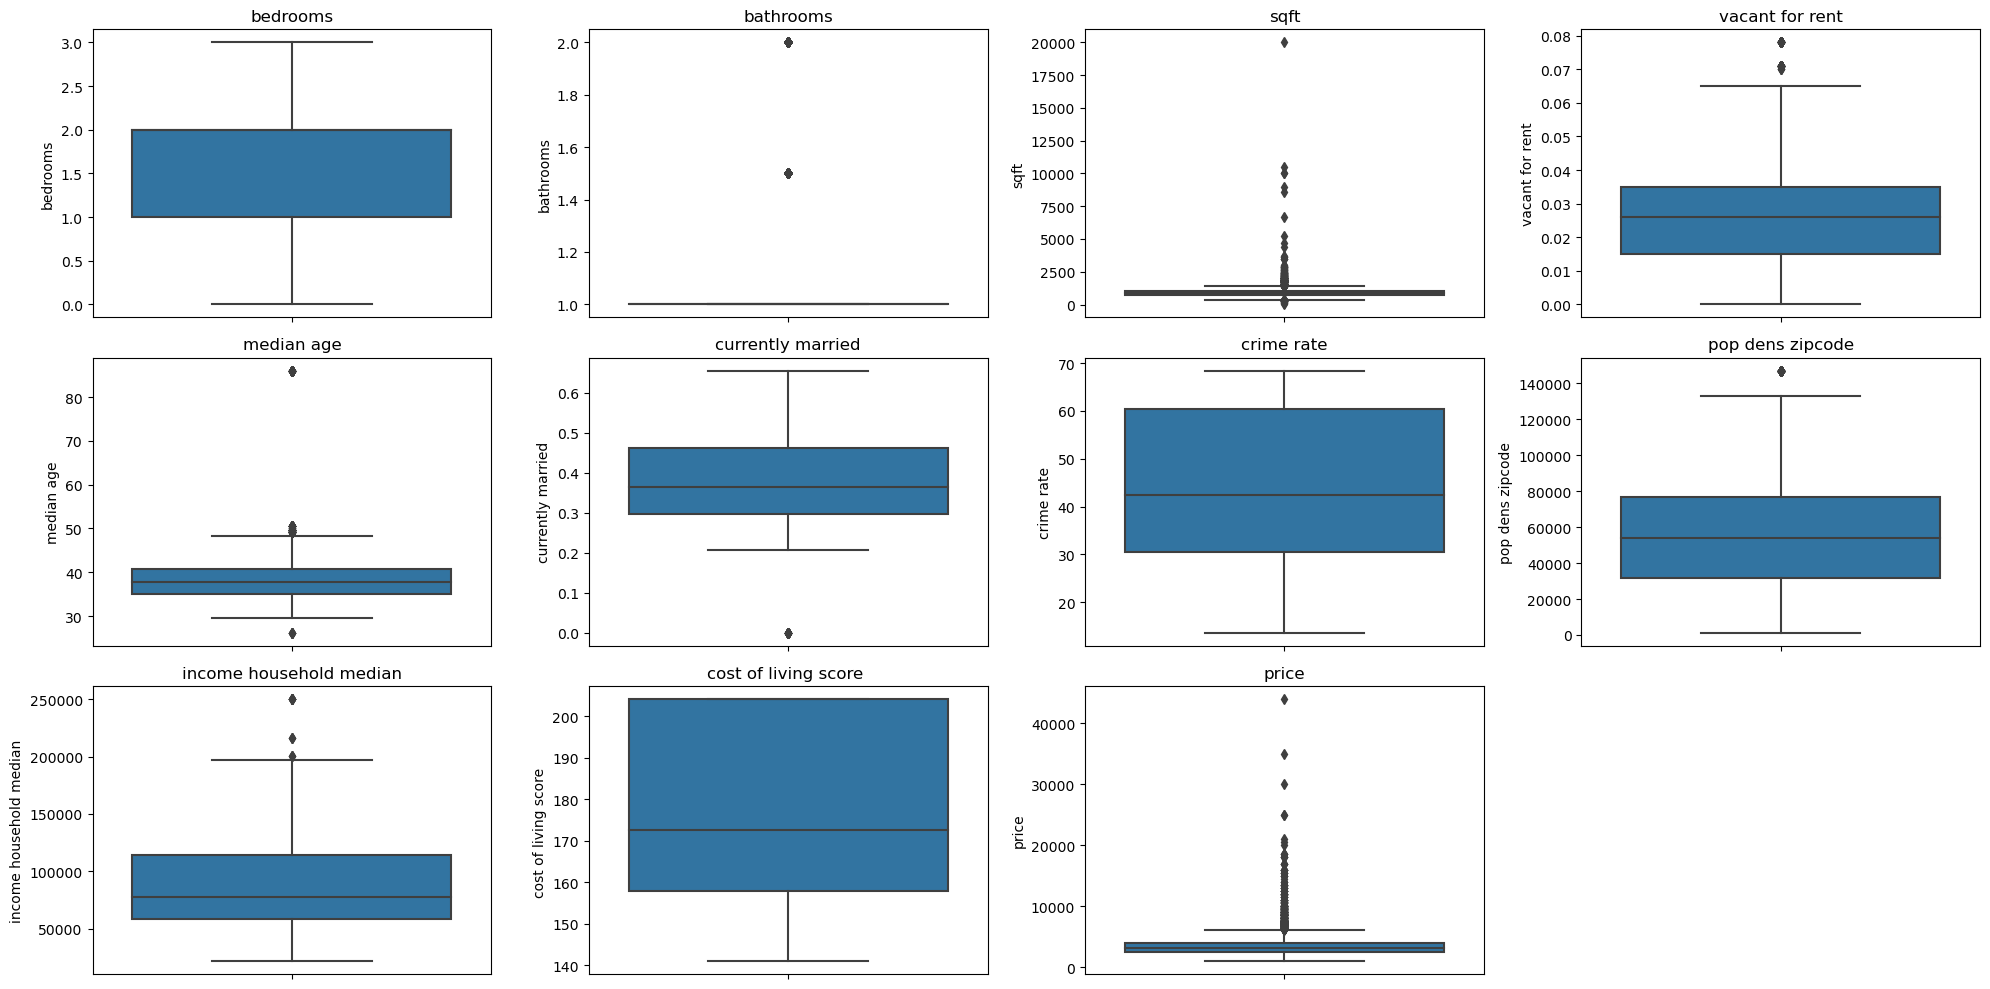

In [81]:
plt.figure(figsize=(20, 10))

# List of columns to plot
columns_to_plot = ['bedrooms', 'bathrooms', 'sqft', 'vacant for rent', 'median age', 'currently married', 'crime rate', 'pop dens zipcode', 'income household median', 'cost of living score ', 'price']

# Generate a boxplot for each specified column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 4, i)  # Adjust grid dimensions as necessary
    sns.boxplot(y=df_filtered[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [88]:
df_filtered.describe()

,zpid,zipcode,bedrooms,bathrooms,sqft,vacant for rent,median age,currently married,crime rate,pop dens zipcode,income household median,cost of living score,price
count,7.314000e+03,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000
mean,1.323094e+09,10698.116489,1.686355,1.178357,907.890347,0.026567,38.471411,0.377768,42.574528,57670.531105,86453.471014,176.605031,3565.558791
std,8.970547e+08,580.396766,0.948453,0.368877,440.928789,0.014160,6.191669,0.099476,16.669612,33716.492368,36271.111875,22.403999,1925.412508
min,2.977812e+07,10001.000000,0.000000,1.000000,10.000000,0.000000,26.200000,0.000000,13.600000,1261.200000,21846.000000,141.000000,1000.000000
25%,3.523039e+08,10028.000000,1.000000,1.000000,750.000000,0.015000,35.000000,0.297000,30.400000,31902.900000,58850.000000,157.900000,2550.000000
50%,2.060692e+09,10472.000000,2.000000,1.000000,900.000000,0.026000,37.700000,0.365000,42.500000,53801.600000,77551.000000,172.500000,3150.000000
75%,2.095869e+09,11225.000000,2.000000,1.000000,1000.000000,0.035000,40.700000,0.461000,60.400000,76855.100000,114427.000000,204.100000,3994.500000
max,2.146837e+09,11697.000000,3.000000,2.000000,20000.000000,0.078000,86.000000,0.655000,68.400000,146955.300000,250001.000000,204.100000,44000.000000


In [89]:
# Define your thresholds
sqft_lower_bound = 750
sqft_upper_bound = 1000
price_lower_bound = 2550
price_upper_bound = 3994

# Cap and floor the values
df_filtered['sqft'] = df_filtered['sqft'].clip(lower=sqft_lower_bound, upper=sqft_upper_bound)
df_filtered['price'] = df_filtered['price'].clip(lower=price_lower_bound, upper=price_upper_bound)

df_filtered.describe()

C:\Users\Siqi Lai\AppData\Local\Temp\ipykernel_2432\2500300037.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sqft'] = df_filtered['sqft'].clip(lower=sqft_lower_bound, upper=sqft_upper_bound)
C:\Users\Siqi Lai\AppData\Local\Temp\ipykernel_2432\2500300037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['price'] = df_filtered['price'].clip(lower=price_lower_bound, upper=price_upper_bound)


,zpid,zipcode,bedrooms,bathrooms,sqft,vacant for rent,median age,currently married,crime rate,pop dens zipcode,income household median,cost of living score,price
count,7.314000e+03,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000,7314.000000
mean,1.323094e+09,10698.116489,1.686355,1.178357,871.991797,0.026567,38.471411,0.377768,42.574528,57670.531105,86453.471014,176.605031,3225.354936
std,8.970547e+08,580.396766,0.948453,0.368877,109.275300,0.014160,6.191669,0.099476,16.669612,33716.492368,36271.111875,22.403999,580.993558
min,2.977812e+07,10001.000000,0.000000,1.000000,750.000000,0.000000,26.200000,0.000000,13.600000,1261.200000,21846.000000,141.000000,2550.000000
25%,3.523039e+08,10028.000000,1.000000,1.000000,750.000000,0.015000,35.000000,0.297000,30.400000,31902.900000,58850.000000,157.900000,2550.000000
50%,2.060692e+09,10472.000000,2.000000,1.000000,900.000000,0.026000,37.700000,0.365000,42.500000,53801.600000,77551.000000,172.500000,3150.000000
75%,2.095869e+09,11225.000000,2.000000,1.000000,1000.000000,0.035000,40.700000,0.461000,60.400000,76855.100000,114427.000000,204.100000,3993.750000
max,2.146837e+09,11697.000000,3.000000,2.000000,1000.000000,0.078000,86.000000,0.655000,68.400000,146955.300000,250001.000000,204.100000,3994.000000


In [91]:
df_filtered.to_csv('cleaned_data.csv', index=False)